## Dependencies

In [14]:
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

from time import time

In [15]:
# Import the best device available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Choice of dataset

The first possible dataset is **permuted MNIST**. The model will be trained on different variations of the same dataset. Each variation corresponds to a different classification task as stated in the paper. The permuted MNIST dataset consists in fist flattening the black and white images of hand written digits and applying a random permutation to the whole dataset of flattened pixel data vectors.

The second possible dataset is **rotated MNIST**. Each variation corresponds to MNIST rotated by $ 10(i-1)$ degree if $i$ is the index of the variation/task.

In [16]:
BATCH_SIZE = 128
#VAL_FRAC   = 0.1
DEBUG      = False # Accelerates training by ~90% by only uses 10% of training dataset.
                   # Switch off for generating figures, switch on for testing code.

def take_subset(dataset, frac):
    subset_size = int(frac * len(dataset))
    indices = torch.randperm(len(dataset))[:subset_size]
    return Subset(dataset, indices)

def generate_permuted_mnist(i):
    """
    Generates a permuted MNIST dataset with random permutation
    
    author = Jules
    """

    # Define transform
    TRANSFORM = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
    ])

    # load dataset
    raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=TRANSFORM, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=TRANSFORM, download=True)

    # Permute dataset splits
    permutation = torch.randperm(28 * 28)
    raw_dataset.data = raw_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)
    test_dataset.data = test_dataset.data.view(-1, 28 * 28)[:, permutation].view(-1, 28, 28)
    
    return raw_dataset, test_dataset

def generate_rotated_mnist(i):
    """
    Generates a rotated MNIST dataset

    author = Pierre
    """

    # Define transform
    TRANSFORM = transforms.Compose([transforms.ToTensor()])

    # Load datasets
    raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=TRANSFORM, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=TRANSFORM, download=True)

    # Rotate dataset splits
    angle = 2 * np.pi * i / 10  # Define the rotation angle

    def rotate_dataset(dataset, angle):
        rotated_data = []
        for j in range(len(dataset)):
            img, label = dataset[j]
            img = transforms.functional.rotate(img, angle * 180 / np.pi) # Rotate image
            img = img.view(-1)
            rotated_data.append((img, label))
        return rotated_data

    raw_dataset = rotate_dataset(raw_dataset, angle)
    test_dataset = rotate_dataset(test_dataset, angle)

    return raw_dataset, test_dataset


def generate_tasks(n_tasks, dataset_gen):
    """
    Used to generate N dataloaders corresponding to N different tasks.
    Training dataset is split into training and validation.

    author = Jules
    """

    raw_datasets = []
    test_datasets = []

    # Generate datasets
    for i_task in range(n_tasks):
        raw_dataset, test_dataset = dataset_gen(i_task)

        # DEBUG CODE
        if DEBUG:
            raw_dataset = take_subset(raw_dataset, 0.1)
            test_dataset = take_subset(test_dataset, 0.1)

        raw_datasets.append(raw_dataset)
        test_datasets.append(test_dataset)

    train_loaders = []
    #val_loaders = []
    test_loaders = []

    # Generate dataloaders
    for i_task in range(n_tasks):
        raw_dataset = raw_datasets[i_task]
        test_dataset = test_datasets[i_task]

        # Split train into train and validation
        train_dataset = raw_dataset
        #val_size = int(VAL_FRAC * len(raw_dataset))
        #train_size = len(raw_dataset) - val_size
        #torch.manual_seed(42)  # make sure epochs have the same validation dataset
        #train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [train_size, val_size])

        # Turn into data loaders
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        #val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        print(f'Task {i_task + 1} Splits: {len(train_dataset)} train, {len(test_dataset)} test')

        train_loaders.append(train_loader)
        #val_loaders.append(val_loader)
        test_loaders.append(test_loader)

    return train_loaders, test_loaders


## Util Functions

### Validation

Appendix 4.1 suggests figure 3B was realized using early stopping, which requires the use of a validation split. For this reason, we split the training dataset into a validation and training dataset. Early stopping is as follows in the paper: if validation is seen increasing 5 consecutive times (arbitrary threshold), training is stopped and the model performing the best on previous epochs is kept. This requires to periodically save the dataset and load again the best performing model at the end of the training function.

For figure 2A, we don't need to compute a validation loss, so no need to split the training dataset into training and validation splits. It is not fully optimal, but we can use test accuracy to tell if the model is overfitting or if it's still
learning.

In [17]:
def evaluate_accuracy(
    model: torch.nn.Module,
    test_dataloader: DataLoader,
    device: torch.device,
):
    """
    Evaluate test accuracy of the given model on the test split
    """

    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [18]:
def validate_epoch(
    model: torch.nn.Module,
    val_dataloader: DataLoader,
    criterion,
    device: torch.device,
):
    """
    This function validates the model on the validation dataset.
    """

    val_loss = 0.0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_dataloader):
            # move data and target to device
            data, target = data.to(device), target.to(device)

            # do the forward pass
            output = model(data)

            # compute the loss
            try:    #Case of EWC
                loss = criterion(output, target, model)
            except TypeError:
                loss = criterion(output, target)


            # print statistics
            val_loss += loss.item()

    return val_loss / len(val_dataloader)

### Training Function

In [19]:
def train_epoch(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    device: torch.device,
):
    """
    Training function. Loads the batch, perform forward pass, compute gradients and perform backward pass.
    Only difference is that you can pass the loss function as an argument.
    This allows to use a simple cross entropy loss function, or a more complex one including L2 or EWC regularization.
    """

    train_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        try:
            # For EWC, which uses 3 parameters instead of 2
            loss = criterion(output, target, model)
        except TypeError:
            # For SGD and L2
            loss = criterion(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        # print statistics
        train_loss += loss.item()

    return train_loss / len(train_dataloader)

def fit(
    model: torch.nn.Module,
    train_dataloader: DataLoader,
    #val_dataloader: DataLoader,
    test_dataloaders: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    criterion,
    epochs: int,
    device: torch.device,
    i_task: int,
):
    """
    The fit method calls the train_epoch() method for a specified
    number of epochs and returns the train and validation losses.

    author = Jules
    """

    global N_TASKS

    # keep track of losses and accuracies
    train_losses = []
    #val_losses = []
    test_accuracies = [[] for _ in range(N_TASKS)]
    for epoch in range(epochs):

        t = time() # current time

        # train function
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        train_losses.append(train_loss)

        # validate epoch
        #val_loss = validate_epoch(
        #    model=model,
        #    val_dataloader=val_dataloader,
        #    criterion=criterion,
        #    device=device,
        #)
        #val_losses.append(val_loss)

        # compute test accuracies on all tasks so far
        for task_idx in range(N_TASKS):
            if task_idx <= i_task:
                test_accuracy = evaluate_accuracy(
                    model=model,
                    test_dataloader=test_dataloaders[task_idx],
                    device=device,
                )
                #print(f'-- accuracy on task {task_idx} -> {test_accuracy}')
            else:
                test_accuracy = 0
            test_accuracies[task_idx].append(test_accuracy)

        # step scheduler if needed
        if scheduler != None:
            scheduler.step()

        dt = time() - t # time difference
        print(f"Epoch [{epoch + 1}/{epochs}]: train={round(train_loss, 4)} test={get_latest_accuracies(test_accuracies)} ({round(dt, 1)}s)")

    return train_losses, test_accuracies

def get_latest_accuracies(test_accuracies):
    latest_accuracies = []
    
    for task_idx in range(N_TASKS):
        latest_accuracies.append(round(test_accuracies[task_idx][-1], 4))

    return latest_accuracies

## EWC Loss Function

SGD and SGD with L2 regularization are already supported by PyTorch (using the SGD optimizer and weight decay for L2 regularization), however EWC requires full re-implementation.

In [20]:
from copy import deepcopy

class EWC(object):
    """
    Util class used to save a model snapshot, and later apply the
    corresponding EWC penalty during training.

    Source = https://github.com/moskomule/ewc.pytorch/blob/master/utils.py

    author = Pierre
    """

    def __init__(self, model, dataset: list):

        self.model = model
        self.dataset = dataset

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = p.data

    def _diag_fisher(self):
        """
        Precomputes Fisher information to be used later when
        applying penalties.
        """

        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = p.data

        self.model.eval()
        for batch_idx, (data, target) in enumerate(self.dataset):
            data, target = data.to(device), target.to(device)
            self.model.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, new_model):
        """
        Computes loss function penalty, basically a weighted sum of
        quadratic error.
        """
        loss = 0
        for n, p in new_model.named_parameters():
            _loss = 1/2 *self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

def generate_ewc_loss(penalties, lambda_regul):
    """
    Generates an EWC loss function given list of penalties to apply (instances of EWC class)
    and value of regularization parameter lambda.
    
    author = Pierre
    """

    def ewc_loss_function(output, target, new_model):
        loss = F.cross_entropy(output, target)
        print(f'raw loss = {loss}')
        for penalty in penalties:
            raw_penalty = penalty(new_model)
            loss += lambda_regul * raw_penalty
            print(f'   raw penalty = {raw_penalty}')
        return loss

    return ewc_loss_function

## Model architecture

The model being used in the paper for figure 2A is a straight forward neural network, with two hidden layers and 400 neurons per hidden layer. The size of the hidden layer has a rather small influence on training speed most likely due to the hardware overhead of loading dataset batches. Therefore, we decided to use the exact same model architecture as the one used in the paper.

In [21]:
class SmallNet(torch.nn.Module):
    """
    author = Jules
    """

    def __init__(self):
        super(SmallNet, self).__init__()

        self._input_size = 28 * 28
        self._n_ff       = 400
        self._n_output   = 10

        self.ff1 = torch.nn.Linear(self._input_size, self._n_ff)
        self.ff2 = torch.nn.Linear(self._n_ff, self._n_ff)
        self.ff7 = torch.nn.Linear(self._n_ff, self._n_output)

    def forward(self, x):
        
        x = F.relu(self.ff1(x)) # first ff layer
        x = F.relu(self.ff2(x)) # first ff layer

        x = self.ff7(x) # classification layer
        
        return x

print("Model Parameters: ", sum(p.numel() for p in SmallNet().parameters()))

Model Parameters:  478410


## Training Script

The training script generates $N$ different tasks and calls the `fit(..)` function as many times as needed. It then saves the test metric for the next script to generate figure 2A.

No scheduler seems to have been used in the paper, so we are not using any here.

In [ ]:
#################################################################################
# N_EPOCHS    = Number of epochs per task.
# N_TASKS     = Number of tasks to train the model on.
# DATASET_GEN = Type of tasks. We can choose between permuted MNIST and rotated MNIST
# REGUL_TYPE  = Type of regularization. Very important for the paper, as it changes the training process.
#               - `SGD` | Classic SGD with no regularization term
#               - `L2`  | SGD with L2 regularization term
#               - `EWC` | SGD with elastic weight consolidation regularization
#################################################################################
N_EPOCHS    = 20
N_TASKS     = 3
DATASET_GEN = generate_permuted_mnist
REGUL_TYPES = [
    #'SGD',
    #'L2',
    'EWC',
]
PLOT_CURVES = True

# Every model sees the same 3 random permutation
train_dataloaders, test_dataloaders = generate_tasks(N_TASKS, DATASET_GEN)

# Regularization method.
for REGUL_TYPE in REGUL_TYPES:
    print(f'\n\nUsing regularization method {REGUL_TYPE}')

    # Initialize model
    model = SmallNet()
    model.to(device)

    # Loss, optimizer and scheduler
    if REGUL_TYPE == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
        criterion = F.cross_entropy
    elif REGUL_TYPE == 'L2':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)
        criterion = F.cross_entropy
    elif REGUL_TYPE == 'EWC':
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
        criterion = F.cross_entropy # See below for more detail
    else:
        raise Exception('Invalid regularization')

    full_train_losses    = []
    #full_val_losses      = []
    full_test_accuracies = [[] for _ in range(N_TASKS)]

    # Index of current task. In between these tasks (loop iterations), the
    # is model NOT reset. This corresponds to the column index in figure 2A
    penalties = []
    for i_task in range(N_TASKS):

        # Get tasks
        train_dataloader = train_dataloaders[i_task]
        #val_dataloader = val_dataloaders[i_task]
        print(f'Training on task {i_task + 1}...')

        if REGUL_TYPE == 'EWC':
            penalties.append(EWC(model, dataset=train_dataloaders[i_task]).penalty) # Add one regularization per task, as proposed by Kirkpatrick et al.                
            criterion = generate_ewc_loss(penalties, 10) # At every new task the model sees, the loss function needs to be updated.

        # Fit on task
        train_losses, test_accuracies = fit(
            model=model,
            train_dataloader=train_dataloader,
            #val_dataloader=val_dataloader,
            test_dataloaders=test_dataloaders,
            optimizer=optimizer,
            scheduler=None,
            criterion=criterion,
            epochs=N_EPOCHS,
            device=device,
            i_task=i_task,
        )

        full_train_losses += train_losses
        #full_val_losses += val_losses
        for task_idx in range(N_TASKS):
            full_test_accuracies[task_idx] += test_accuracies[task_idx]

    # Save model and metrics for fig 2A
    #torch.save(model.state_dict(), f'{REGUL_TYPE}.pt')
    #np.save(f'{REGUL_TYPE}_train_loss.npy', full_train_losses)
    #np.save(f'{REGUL_TYPE}_val_loss.npy', full_val_losses)
    np.save(f'2a_{REGUL_TYPE}_test_accuracy.npy', np.array(full_test_accuracies))

    if PLOT_CURVES:

        # Plot metrics wrt epoch index
        print('Plotting training curves & metrics...')
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Plot training and validation losses
        axs[0].plot(full_train_losses, label='Train')
        #axs[0].plot(full_val_losses, label='Validation')
        axs[0].legend()
        axs[0].set_title('Training Curves')

        # Plot test accuracy
        for task_idx in range(N_TASKS):
            axs[1].plot(full_test_accuracies[task_idx], label=f'Task {task_idx + 1}')
        axs[1].legend()
        axs[1].set_title('Test Accuracy')

        plt.show()

print('Done!');

Task 1 Splits: 60000 train, 10000 test
Task 2 Splits: 60000 train, 10000 test
Task 3 Splits: 60000 train, 10000 test


Using regularization method EWC
Training on task 1...
Epoch [1/20]: train=2.2965 test=[0.224, 0, 0] (9.9s)
Epoch [2/20]: train=2.2782 test=[0.4705, 0, 0] (9.3s)
Epoch [3/20]: train=2.2573 test=[0.5973, 0, 0] (9.0s)
Epoch [4/20]: train=2.2314 test=[0.6403, 0, 0] (9.0s)


## Generate Figure 2A

Follow these steps to generate figure 2A. You can then redo all these steps after changing the dataset from permuted to rotated MNIST using the option `DATASET_GEN` in the script above.

- Run the script above to generate test metrics for the three regularization methods.
- Run the following script which compiles all curves above into figure 2A.

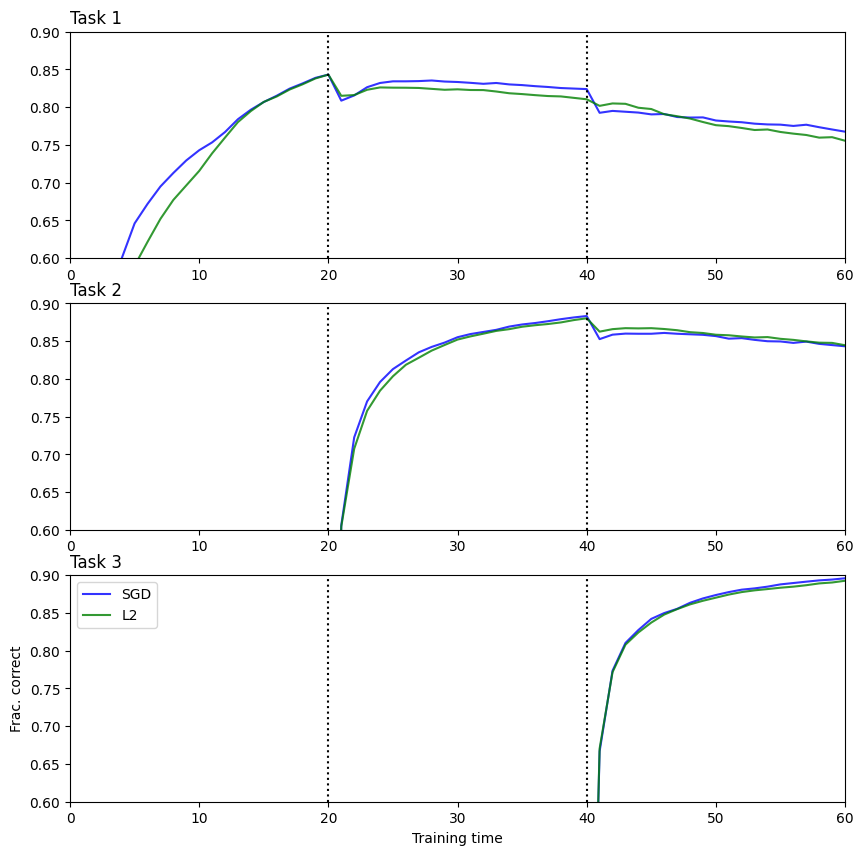

In [33]:
COLOR_DICT = {
    'SGD':"blue",
    'L2': 'green',
    'EWC':'red'
}

fig, axs = plt.subplots(N_TASKS, 1, figsize=(10, 10))
x_values = list(range(1, 1 + N_TASKS * N_EPOCHS))

# Labels and X-Y scales
for task_idx in range(N_TASKS):
    axs[task_idx].set_title(f'Task {task_idx + 1}', loc='left')
    axs[task_idx].set_ylim(.6, .9)
    axs[task_idx].set_xlim(0, N_TASKS * N_EPOCHS)

# Plot data
for file_name in COLOR_DICT:
    test_accuracy = np.load(f'2a_{file_name}_test_accuracy.npy')
    for task_idx in range(N_TASKS):
        axs[task_idx].plot(x_values, test_accuracy[task_idx], label=file_name, color = COLOR_DICT[file_name], alpha = 0.8)

# Plot dotted lines like on figure 2A
for task_idx in range(N_TASKS):
    for i in range(1, N_TASKS):
        axs[task_idx].axvline(x=i * N_EPOCHS, color='black', linestyle=':')

plt.ylabel('Frac. correct')
plt.xlabel('Training time')
plt.legend()

plt.show()